# Intoduction to NLP Fundamentals in Tensorflow

Derive information from text or speech

## Helper Functions

In [1]:
import helper_functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Evaluation Function

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_true, preds):

    return {
        "Accuracy Score": (accuracy_score(y_true, preds) * 100),
        "Precision Score": (precision_score(y_true, preds)* 100),
        "Recall Score": (recall_score(y_true, preds)* 100),
        "F1-Score": (f1_score(y_true, preds)* 100)
    }

## Get Text Data Set

In [3]:
# Kaggle's intro to NLP dataset - target [1 - disaster, 0 - not disaster]
import pandas as pd
train_data = pd.read_csv('data/nlp-getting-started/train.csv')
test_data = pd.read_csv("data/nlp-getting-started/test.csv")

## Visualizing Text Dataset

In [4]:
# Shuffle Data
train_data_shuffled = train_data.sample(frac = 1, random_state=42)
train_data_shuffled.head(3)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1


In [5]:
# Examples from each class?
train_data_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
# Visualize random training examples
import random
random_index = random.randint(0, len(train_data)-5)
for row in train_data_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")

Target: 1 (real disaster)
Text:
Palestinian Teen Killed Amid Protests Against Arson Attack http://t.co/okVsImoGic

Target: 0 (not real disaster)
Text:
#frontpage: #Bioterror lab faced secret sanctions. #RickPerry doesn't make the cut for @FoxNews #GOPDebate http://t.co/fZujg7sXJg @USATODAY

Target: 0 (not real disaster)
Text:
My emotions are a train wreck. My body is a train wreck. I'm a wreck

Target: 1 (real disaster)
Text:
#Sismo DETECTADO #JapÌ_n 15:41:07 Seismic intensity 0 Iwate Miyagi JST #?? http://t.co/gMoUl9zQ2Q

Target: 0 (not real disaster)
Text:
A look at state actions a year after Ferguson's upheaval http://t.co/GZEkQWzijq



### Split data into training and validation splits

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Split training data into train and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_data_shuffled["text"].to_numpy(),
                                                                                train_data_shuffled["target"].to_numpy(), 
                                                                                test_size=0.1, random_state=42)
print(f"Train: {len(train_sentences)}, Validation: {len(val_sentences)}")

Train: 6851, Validation: 762


## Text Vectorization (Tokenization)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [10]:
# Find the avg number of tokens (words) in each sequence of the training set

max_lenght = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_lenght

15

In [11]:
# Setup the vectorization variables
MAX_VOCAB_LENGTH = 10_000
MAX_LENGTH = max_lenght
OUTPUT_MODE = "int"



text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_LENGTH, # how many words in the vocab
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode=OUTPUT_MODE,
                                    output_sequence_length=MAX_LENGTH, # how long should the sequences be
                                    pad_to_max_tokens=True)

2022-06-01 02:57:59.597618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [13]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

## Embedding Layers

Parameter to care for:
* `input_dim`
* `output_dim`
* `input_length`

In [14]:
from tensorflow.keras import layers

OUTPUT_DIM = 128

embedding = layers.Embedding(input_dim = MAX_VOCAB_LENGTH,
                            output_dim = OUTPUT_DIM,
                            input_length = MAX_LENGTH)

In [15]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence}\
    \n\nEmbedded Sentence:")

# Embed
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text:
 Lily Xo is a sexy cowgirl out in the sticks http://t.co/qew4c5M1xd View and download video    

Embedded Sentence:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01536043, -0.00791342,  0.03378456, ..., -0.028397  ,
          0.0094022 ,  0.03407052],
        [-0.01920433, -0.04355104,  0.01357626, ..., -0.04218745,
         -0.02009963,  0.04114534],
        [-0.02487618,  0.04923302,  0.01479255, ...,  0.03266704,
         -0.01677847,  0.03054232],
        ...,
        [-0.03035313, -0.02886738, -0.00500046, ..., -0.01698917,
          0.02262404,  0.00414308],
        [ 0.01628763, -0.04540346, -0.01206819, ...,  0.04231675,
          0.01388797, -0.03472651],
        [-0.02964337, -0.00303084,  0.03832131, ...,  0.04769753,
          0.04207382, -0.01451921]]], dtype=float32)>

## Modelling Text Data - Running Multiple Experiments

* Model 0: Naive Bayes (baseline)
* Model 1: Feed Forward Neural Network (dense network)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Bidirectional-LSTM Model (RNN)
* Model 5: 1-D Convolutional Network (CNN)
* Model 6: Transfer Learning (Tensorflow Hub)
* Model 7: Model 6, only 10% of data

### Model 0: Naive Bayes - Baseline Model
* `Multinomial Navie Bayes`

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Tokenization and Modelling Pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert text to numbers
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [17]:
# Evaluate the baseline model

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model achieves an accuracy of: {baseline_score * 100:.2f}")

Baseline model achieves an accuracy of: 79.27


In [18]:
# Get Baseline Results
baseline_preds = model_0.predict(val_sentences)
baseline_results = evaluate(y_true=val_labels,
                            preds=baseline_preds)
baseline_results

{'Accuracy Score': 79.26509186351706,
 'Precision Score': 88.6178861788618,
 'Recall Score': 62.643678160919535,
 'F1-Score': 73.4006734006734}

### Model 1: Feed-Forward Neural Net (Dense Network)

In [19]:
# Create Tensorboard Callback 
from helper_functions import create_tensorboard_callback

# Create a directory to save TensoBoard API
SAVE_DIR = "model_logs"

In [20]:
# Build a model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [21]:
# Summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [22]:
# Compile the model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [23]:
# Fit the model

model_1_history = model_1.fit(
    x = train_sentences,
    y = train_labels,
    epochs  = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                            experiment_name = "model_1_dense")]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20220601-025802
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.6146 - accuracy: 0.6830 - val_loss: 0.5365 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4423 - accuracy: 0.8209 - val_loss: 0.4714 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3477 - accuracy: 0.8606 - val_loss: 0.4552 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2853 - accuracy: 0.8917 - val_loss: 0.4622 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2384 - accuracy: 0.9108 - val_loss: 0.4807 - val_accuracy: 0.7822


In [24]:
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs.shape


24/24 [==============================] - 0s 4ms/step


(762, 1)

In [25]:
# Convert Porbs to label format
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs))
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [26]:
# Evaluate the model
model_1_results = evaluate(val_labels, model_1_preds)
print(f"Model_0 Results:\n {baseline_results}")
print(f"Model_1 Results:\n {model_1_results}")

Model_0 Results:
 {'Accuracy Score': 79.26509186351706, 'Precision Score': 88.6178861788618, 'Recall Score': 62.643678160919535, 'F1-Score': 73.4006734006734}
Model_1 Results:
 {'Accuracy Score': 78.21522309711287, 'Precision Score': 81.59722222222221, 'Recall Score': 67.52873563218391, 'F1-Score': 73.89937106918238}


## Recurrent Neural Networks (RNN's)

* Useful for sequence data
* Premise - Use the representation of a previous input to aid the representation of a later input

### Model 2: LSTM

In [27]:
#  Create LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")

In [28]:
# Get summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [29]:
# Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [30]:
model_2_history = model_2.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
    "model_2_LSTM")]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220601-025825
Epoch 1/5
215/215 [==============================] - 16s 51ms/step - loss: 0.2175 - accuracy: 0.9250 - val_loss: 0.6095 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.1517 - accuracy: 0.9429 - val_loss: 0.7018 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1259 - accuracy: 0.9531 - val_loss: 0.6429 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1009 - accuracy: 0.9637 - val_loss: 0.7339 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0836 - accuracy: 0.9672 - val_loss: 1.4988 - val_accuracy: 0.7638


In [31]:
# Calculate results
model_2_results = evaluate(y_true=val_labels,
                           preds=tf.squeeze(tf.round(model_2.predict(val_sentences))))
model_2_results

24/24 [==============================] - 1s 8ms/step


{'Accuracy Score': 76.37795275590551,
 'Precision Score': 80.88235294117648,
 'Recall Score': 63.2183908045977,
 'F1-Score': 70.96774193548387}

In [32]:
baseline_results

{'Accuracy Score': 79.26509186351706,
 'Precision Score': 88.6178861788618,
 'Recall Score': 62.643678160919535,
 'F1-Score': 73.4006734006734}

### Model 3: GRU

In [33]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_GRU")

In [34]:
# Model 3 summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [35]:
# Compile the model
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [36]:
# Fit the model
model_3_history = model_3.fit(
    x = train_sentences, 
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3_GRU")]
)

Saving TensorBoard log files to: model_logs/model_3_GRU/20220601-025916
Epoch 1/5
215/215 [==============================] - 14s 43ms/step - loss: 0.1602 - accuracy: 0.9365 - val_loss: 0.8394 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0774 - accuracy: 0.9721 - val_loss: 1.0614 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0634 - accuracy: 0.9743 - val_loss: 1.0051 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0546 - accuracy: 0.9765 - val_loss: 1.8307 - val_accuracy: 0.7415
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0518 - accuracy: 0.9752 - val_loss: 1.4914 - val_accuracy: 0.7769


In [37]:
# Evaluate the model
model_3_results = evaluate(y_true = val_labels,
                            preds = tf.squeeze(tf.round(model_3.predict(val_sentences))))
model_3_results

24/24 [==============================] - 1s 6ms/step


{'Accuracy Score': 77.69028871391076,
 'Precision Score': 79.47019867549669,
 'Recall Score': 68.96551724137932,
 'F1-Score': 73.84615384615384}

### Model 4: Bidirectional RNN

In [38]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")

In [39]:
# Model 4 summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [40]:
# Compile the model
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [41]:
# Fit the model
model_4_history = model_4.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")]
)

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220601-030004
Epoch 1/5
215/215 [==============================] - 37s 97ms/step - loss: 0.1017 - accuracy: 0.9673 - val_loss: 1.3092 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 20s 92ms/step - loss: 0.0473 - accuracy: 0.9781 - val_loss: 1.9340 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 17s 79ms/step - loss: 0.0452 - accuracy: 0.9793 - val_loss: 1.6221 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 17s 80ms/step - loss: 0.0433 - accuracy: 0.9807 - val_loss: 1.5806 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 16s 76ms/step - loss: 0.0400 - accuracy: 0.9799 - val_loss: 1.9527 - val_accuracy: 0.7664


In [42]:
# Evaluate the model
model_4_results = evaluate(y_true=val_labels,
                            preds=tf.squeeze(tf.round(model_4.predict(val_sentences))))
model_4_results

24/24 [==============================] - 2s 15ms/step


{'Accuracy Score': 76.64041994750657,
 'Precision Score': 76.72955974842768,
 'Recall Score': 70.11494252873564,
 'F1-Score': 73.27327327327329}

## Convolutional Neural Networks for Text

### Model 5: Conv1D

In [43]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, 
                    activation = "relu", padding = "valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_conv1d")

In [44]:
# Model 5 summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)              

In [45]:
# Compile the model
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [46]:
# Fit the model
model_5_history = model_5.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_conv1d")]
)

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220601-030244
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.1696 - accuracy: 0.9384 - val_loss: 0.8563 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0932 - accuracy: 0.9628 - val_loss: 1.0073 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0716 - accuracy: 0.9720 - val_loss: 1.1666 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0618 - accuracy: 0.9737 - val_loss: 1.3029 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0538 - accuracy: 0.9764 - val_loss: 1.3979 - val_accuracy: 0.7585


In [47]:
# Evaluate the model
model_5_evaluate = evaluate(y_true=val_labels,
                            preds = tf.squeeze(tf.round(model_5.predict(val_sentences))))
model_5_evaluate

24/24 [==============================] - 0s 3ms/step


{'Accuracy Score': 75.8530183727034,
 'Precision Score': 75.46583850931677,
 'Recall Score': 69.82758620689656,
 'F1-Score': 72.53731343283582}

## Transfer Learning

### Model 6: Tensorflow Hub Pre-trained Universal Sentence Encoder

In [48]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # embed -> because this model helps with embedding, not classification, use dense

In [49]:
# Create sentence encoder layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [50]:
model_6 = tf.keras.Sequential([
                                sentence_encoder_layer,
                                layers.Dense(64, activation = "relu"),
                                layers.Dense(1, activation = "sigmoid")
                            ], name = "model_6_USE")

In [51]:
# Compile the model
model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [52]:
# Fit the model
model_6_history = model_6.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_6_USE")]
)

Saving TensorBoard log files to: model_logs/model_6_USE/20220601-030349
Epoch 1/5
215/215 [==============================] - 11s 23ms/step - loss: 0.5098 - accuracy: 0.7787 - val_loss: 0.4472 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4167 - accuracy: 0.8142 - val_loss: 0.4368 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4011 - accuracy: 0.8224 - val_loss: 0.4317 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3924 - accuracy: 0.8240 - val_loss: 0.4301 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3850 - accuracy: 0.8288 - val_loss: 0.4277 - val_accuracy: 0.8202


In [53]:
# Evaluate the model
model_6_results = evaluate(y_true = val_labels,
                            preds = tf.squeeze(tf.round(model_6.predict(val_sentences))))
model_6_results

24/24 [==============================] - 1s 13ms/step


{'Accuracy Score': 82.02099737532808,
 'Precision Score': 85.04983388704319,
 'Recall Score': 73.5632183908046,
 'F1-Score': 78.89060092449924}

## Real Life - We have little data to work with 🙁

In [54]:
# Split dataset for 10% of the data only
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [55]:
# Check the targets
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

### Model 7 -> Cloned Model 6

In [56]:
model_7 = tf.keras.models.clone_model(model_6)

#compile model
model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [57]:
# Fit the model
model_7_history = model_7.fit(
    x = train_sentences_10_percent,
    y = train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent_data")]
)

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_data/20220601-030430
Epoch 1/5
22/22 [==============================] - 9s 100ms/step - loss: 0.6687 - accuracy: 0.7095 - val_loss: 0.6483 - val_accuracy: 0.7428
Epoch 2/5
22/22 [==============================] - 1s 51ms/step - loss: 0.6001 - accuracy: 0.8058 - val_loss: 0.5929 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 1s 33ms/step - loss: 0.5266 - accuracy: 0.8277 - val_loss: 0.5391 - val_accuracy: 0.7677
Epoch 4/5
22/22 [==============================] - 1s 50ms/step - loss: 0.4645 - accuracy: 0.8248 - val_loss: 0.5041 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 49ms/step - loss: 0.4232 - accuracy: 0.8321 - val_loss: 0.4897 - val_accuracy: 0.7808


In [58]:
# Evaluate the model
model_7_results = evaluate(y_true = val_labels,
                            preds = tf.squeeze(tf.round(model_7.predict(val_sentences))))
model_7_results             

24/24 [==============================] - 1s 19ms/step


{'Accuracy Score': 78.08398950131233,
 'Precision Score': 79.28802588996764,
 'Recall Score': 70.40229885057471,
 'F1-Score': 74.5814307458143}

## All Model Results

In [59]:
all_model_results = pd.DataFrame({
    "Baseline": baseline_results,
    "Model_1_Dense": model_1_results,
    "Model_2_LSTM": model_2_results,
    "Model_3_GRU": model_3_results,
    "Model_4_bidirectional": model_4_results,
    "Model_5_Conv1D": model_5_evaluate,
    "Model_6_USE": model_6_results,
    "Model_7_USE_10%": model_7_results
})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy Score,Precision Score,Recall Score,F1-Score
Baseline,79.265092,88.617886,62.643678,73.400673
Model_1_Dense,78.215223,81.597222,67.528736,73.899371
Model_2_LSTM,76.377953,80.882353,63.218391,70.967742
Model_3_GRU,77.690289,79.470199,68.965517,73.846154
Model_4_bidirectional,76.640420,76.729560,70.114943,73.273273
Model_5_Conv1D,75.853018,75.465839,69.827586,72.537313
Model_6_USE,82.020997,85.049834,73.563218,78.890601
Model_7_USE_10%,78.083990,79.288026,70.402299,74.581431


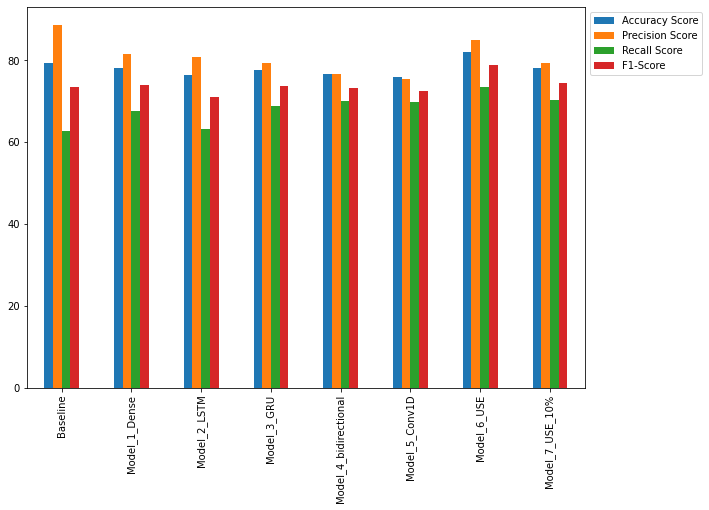

In [60]:
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

Been through 8 models - nothing seems to be overly good.

### Model 8: Using Universal Sentence Encoder + LSTM

In [63]:
from tensorflow.keras import layers


inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences = True)(x)
print(x.shape)
x = layers.LSTM(64, return_sequences = True)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
print(x.shape)
outputs = layers.Dense(1, activation='softmax')(x)
print(x.shape)
model_8 = tf.keras.Model(inputs, outputs, name = "model_8_mix")

# Compile the model
model_8.compile(loss='binary_crossentropy', 
	optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy'])

# Fit the model
model_8_history = model_8.fit(
    x = train_sentences, 
    y = train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels)
    )

(None, 15, 128)
(None, 15, 64)
(None, 15, 64)
(None, 15, 64)
(None, 15, 64)
Epoch 1/5


ValueError: in user code:

    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/vbgupta/.pyenv/versions/3.10.1/lib/python3.10/site-packages/keras/backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 15, 1) vs (None,)).


## Save and Load NLP Models
* HDF5 Format
* The `Save Model` format - default

In [ ]:
# Save model
# model_6.save("models/model_6.h5")

In [ ]:
# Load this model in hdf5 format
# loaded_model_6 = tf.keras.models.load_model("models/model_6.h5",
#                                             custom_objects = {"KerasLayer": hub.KerasLayer})

In [ ]:
# Save Model Format
# model_6.save("models/model_6_savedmodels_format")

In [ ]:
# loaded_model_6_saved_model = tf.keras.models.load_model("models/model_6_savedmodels_format")

## Finding the most wrong answer examples
* If our best model is not perfect, what examples are it getting wrong
* Which ones are the most wrong

In [ ]:
# Create a dataframe with validation sentences, labels and best performing model predictions and probabilities

val_df = pd.DataFrame({
    "text": val_sentences,
    "labels": val_labels,
    "predictions": tf.squeeze(tf.round(model_6.predict(val_sentences))),
    "probabilities": tf.squeeze(model_6.predict(val_sentences))
})
val_df

24/24 [==============================] - 0s 13ms/step


,text,labels,predictions,probabilities
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.210724
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.830966
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.989556
3,@camilacabello97 Internally and externally scr...,1,0.0,0.247919
4,Radiation emergency #preparedness starts with ...,1,1.0,0.742405
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.133825
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.114361
759,FedEx will no longer transport bioterror patho...,0,1.0,0.919105
760,Crack in the path where I wiped out this morni...,0,1.0,0.735324


In [ ]:
# Find wrong preds, and sort by pred probs
most_wrong = val_df[val_df["labels"] != val_df["predictions"]].sort_values("probabilities", ascending = False)
most_wrong

,text,labels,predictions,probabilities
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.941575
759,FedEx will no longer transport bioterror patho...,0,1.0,0.919105
628,@noah_anyname That's where the concentration c...,0,1.0,0.884292
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.860566
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.855491
...,...,...,...,...
233,I get to smoke my shit in peace,1,0.0,0.051732
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.047418
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.042397
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038329


## Predictions on Test Data

In [ ]:
test_sentences = test_data["text"].to_list()

# Making predictions of 10 test sentences and visualizing them
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_probs = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_probs)
    print(f"Pred: {int(pred)}, Prob: {pred_probs}\n")
    print(f"Text: {test_sample}\n")
    print("-----\n")

1/1 [==============================] - 0s 46ms/step
Pred: 1, Prob: 0.8445082306861877

Text: The Cafe Run by Acid Attack Survivors in #India http://t.co/XtVRJMRREs http://t.co/ndvlAPJvQL

-----

1/1 [==============================] - 0s 50ms/step
Pred: 0, Prob: 0.08521749824285507

Text: @ESM_Campy and he used werewolf on me also idiota I was tea bagging your body for like 7 minutes while he was fighting someone else

-----

1/1 [==============================] - 0s 52ms/step
Pred: 0, Prob: 0.1070595234632492

Text: @JagexSupport can u remove the email of the hijacker pls !! YKJL is my ign. i need to recover but pls block so they dont break bank pin!

-----

1/1 [==============================] - 0s 45ms/step
Pred: 0, Prob: 0.09905754029750824

Text: Why is it that my pinky feels like it's lit on fire ? #freaky

-----

1/1 [==============================] - 0s 92ms/step
Pred: 1, Prob: 0.9944483041763306

Text: Arson suspect linked to 30 fires caught in Northern California http://t.co/H

In [ ]:
# View Test Data
test_data[["text", "id"]].head()

,text,id
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",2
2,"there is a forest fire at spot pond, geese are...",3
3,Apocalypse lighting. #Spokane #wildfires,9
4,Typhoon Soudelor kills 28 in China and Taiwan,11


In [ ]:
# View Submission File - Kaggle
sub_file = pd.read_csv("data/nlp-getting-started/sample_submission.csv")
print(sub_file.columns)
sub_file.head()

Index(['id', 'target'], dtype='object')


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
submission_file = pd.DataFrame({
    "id": test_data["id"],
    "target": tf.squeeze(tf.round(model_6.predict(test_data["text"].to_list())))
})
submission_file["target"] = submission_file["target"].astype(int)
submission_file.head()

102/102 [==============================] - 2s 17ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
submission_file.to_csv("data/nlp-getting-started-submission-1.csv", index = False) # 0.80570 -> accuracy

## Predicting on Tweets from Twitter

In [ ]:
sentence = "Tesla Plaid S cruising around Austin with volume at 11 is sublime" #thanks elon

answer = int(tf.squeeze(tf.round(model_6.predict([sentence]))))
print(f"Elon's Tweet is: {answer}")

1/1 [==============================] - 0s 80ms/step
Elon's Tweet is: 0
